In [4]:
import learn_kuramoto_files as lk
import importlib as imp
imp.reload(lk)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import signal

import networkx as nx

C:\Users\mpanaggio\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
A=np.matrix([[1,1],[0,2]])
v=np.matrix([[-1],[3]])
print(A*v)
print(np.multiply(A,v))
print(A.mean(axis=1))

[[2]
 [6]]
[[-1 -1]
 [ 0  6]]
[[1.]
 [1.]]


In [47]:

from scipy.integrate import solve_ivp
from functools import partial
def dydt_kuramoto(t,y,params):
    ''' 
    dydt_kuramoto(t,y,params): 
        Right hand side of kuramoto ODE.
    
    Inputs:
    t: current time
    y: vector of phases (n,)
    params: dictionary with: 
                'w': scalar or (n,1)
                'A': (n,n)
                'K': scalar 
                'Gamma': vectorized function
       
    Outputs:  
    dydt: numpy vector (n,1)
    
    '''    
    correctA=np.matrix(params['A'])
    correctw=np.matrix(params['w'])
    K=params['K']
    model_func=params['Gamma']
    y=np.matrix(y)% (2*np.pi)
#     print("y",y.shape)
#     print("A",correctA.shape)
#     print("w",correctw.shape)
#     print("K",K)
#     print("other",np.mean(np.multiply(correctA,model_func(y.T-y)),axis=1).shape)
    # dydt=correctw+K*np.mean(np.multiply(correctA,model_func(y.T-y)),axis=1) # correctw.squeeze()
    normalizedA=np.multiply(A,1/A.sum(axis=1).reshape(-1,1))
    dydt=correctw+K*np.sum(np.multiply(normalizedA,model_func(y.T-y)),axis=1) # correctw.squeeze()
    return dydt

def solve_kuramoto_ode(dt,params,tmax=500.0,IC=[]):
    ''' 
    dydt_kuramoto_ode(dt,params,tmax): 
        Solve kuramoto ODE using RK45
    
    Inputs:
    dt: time step
    params: dictionary with: 
                'w': scalar or (n,1)
                'A': (n,n)
                'K': scalar 
                'Gamma': vectorized function
    tmax: maximum integration time.
       
    Outputs:  
    t: vector of time values (numsteps,1)
    y: matrix of phases (numsteps,num_oscillators)
    
    ''' 
    num_osc=params['w'].shape[0]
    tmin=0.0 # start time
    if len(IC)==0:
        IC=np.array(2.0*np.pi*np.random.rand(num_osc)) # initial condition
    numsteps=int(np.round((tmax-tmin)/dt)) # number of steps to take
    t_eval=np.linspace(tmin,tmax,numsteps+1,endpoint=True)
    sol=solve_ivp(partial(dydt_kuramoto,params=params), 
                  (tmin,tmax),
                  IC,
                  method='RK23', # RK45
                  t_eval=t_eval,
                  vectorized=True)
    t=(np.reshape(sol.t,(-1,1)))
    y=(sol.y.T)
    return t,y

In [48]:
A=np.random.rand(2,2)
print(A)
print(np.multiply(A,1/A.sum(axis=1).reshape(-1,1)))

[[0.83560193 0.76404655]
 [0.25447209 0.18569533]]
[[0.52236597 0.47763403]
 [0.57812568 0.42187432]]


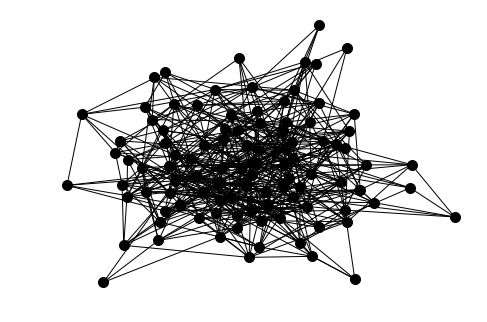

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}


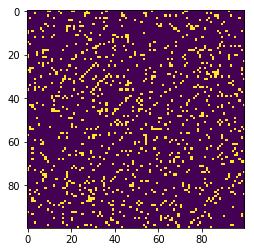

In [153]:
## define model parameters
num_osc=100
mu_freq=0  # mean natural frequency
sigma_freq=0.1  # std natural frequency

G=nx.random_regular_graph(d=20, n=num_osc, seed=1)
G=nx.erdos_renyi_graph(num_osc,p=0.1, seed=1)
A=nx.adjacency_matrix(G).todense()
nx.draw_spring(G,node_color='black',node_size=100)
plt.show()
community_dict=dict(zip(range(0,num_osc),[0]*int(num_osc/2)+[1]*int(num_osc/2)))
print(community_dict)
random_seed=-1 # -1 to ignore
alpha=1.0#np.pi/2-0.01
#coupling_function=lambda x: np.sin(x-alpha)  # Gamma from kuramoto model
coupling_function=lambda x: np.sin(x-alpha)+0.3*np.sin(2*x)  # Gamma from kuramoto model
#coupling_function=lambda x: np.sin(x-0.2)+0.1*np.cos(2*x) # Gamma from kuramoto model

##############################################################################
## define numerical solution parameters
dt=0.1     # time step for numerical solution
tmax=5000.0    # maximum time for numerical solution
noise_level=0.0 # post solution noise added
num_repeats=1 # number of restarts for numerical solution
## Note: the  loop parameter value will overwrite the value above
#G=nx.from_numpy_matrix(A)
#print(G.degree)
plt.imshow(A)
plt.show()

In [154]:
system_params={'w': lk.random_natural_frequencies(num_osc,mu=mu_freq,sigma=sigma_freq,seed=random_seed),
        'A': A,
        'K': 1.0,
        'Gamma': coupling_function
        }
solution_params={'dt':dt,
                 'tmax':tmax,
                 'noise': noise_level,
                 'ts_skip': 1, # don't skip timesteps
                 'num_repeats': num_repeats
                 }
print(solution_params)
print(system_params['w'].shape)
print(system_params['A'].shape)
print(system_params['K'])
print(system_params['Gamma'])
print(community_dict)

{'dt': 0.1, 'tmax': 5000.0, 'noise': 0.0, 'ts_skip': 1, 'num_repeats': 1}
(100, 1)
(100, 100)
1.0
<function <lambda> at 0x0000000020590A60>
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}


In [155]:
## generate training data
#tv=np.linspace(0.0,tmax,int(tmax/dt+1))

# chimera ic
#tmp=[x for x in community_dict.values() if x==0]
#IC=np.concatenate([0.01*np.random.randn(len(tmp))-0.1,2*np.random.randn(num_osc-len(tmp))])
IC=10*np.random.randn(num_osc)
ndivisions=100

for k in range(1,ndivisions+1):
    tend=tmax/(ndivisions+0.0)
    if k==1:
        tv,phases=solve_kuramoto_ode(dt,system_params,tend,np.angle(np.exp(1j*IC)))
    else:        
        ttmp,phasestmp=solve_kuramoto_ode(dt,system_params,tend,np.angle(np.exp(1j*phases[-1,:])))
        tv=np.concatenate([tv[:-1],ttmp+tmax/(ndivisions+0.0)*(k-1)],axis=0)
        phases=np.concatenate([phases,phasestmp[1:,:]],axis=0)

        
    
#old_phases,new_phases=lk.generate_data(system_params,
#                                       solution_params,)

(50001, 1)


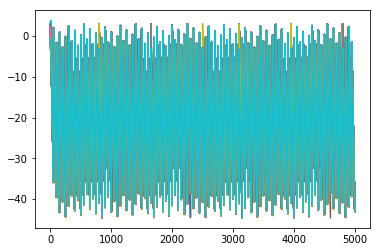

In [156]:
print(tv.shape)
import matplotlib.pyplot as plt
color_dict={0:'b',1:'r'}
plt.plot(tv,phases)
#plt.plot(tv,phases-phases[:,0].reshape(-1,1))  # rotating reference 
plt.show()

(50001, 100)


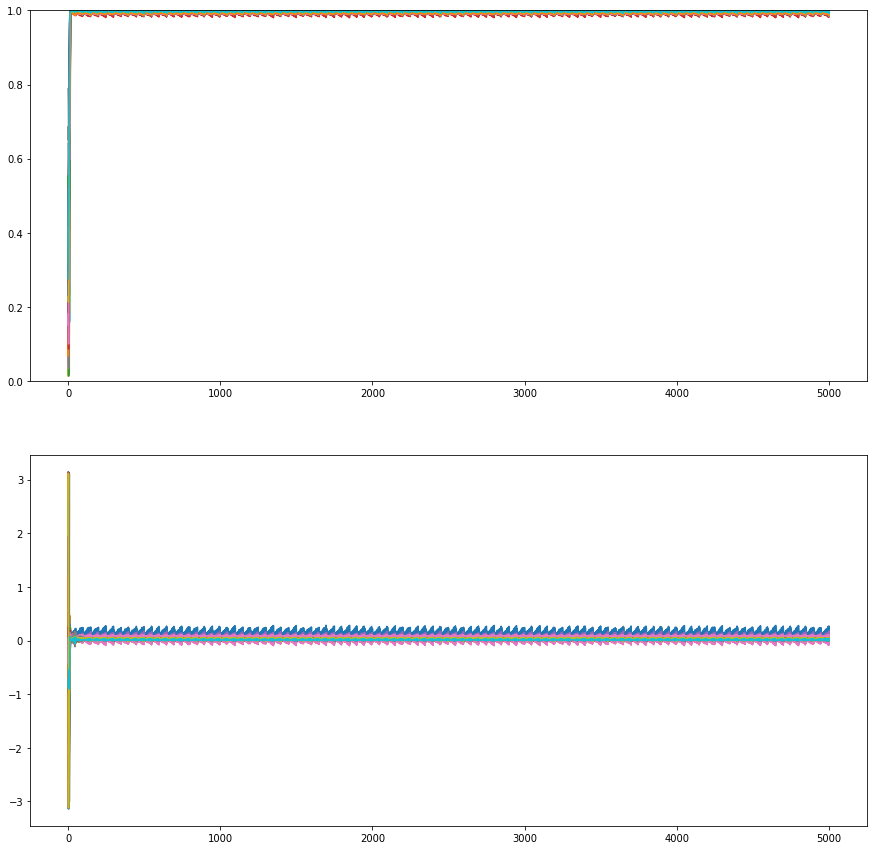

In [157]:
print(phases.shape)
def get_local_op(phases,A,community_dict,axis=0):
    if axis==1:
        phases=phases.T
    R=0*phases
    Psi=0*phases
    
    normalizedA=np.multiply(A,1/A.sum(axis=1).reshape(-1,1))
    for k in range(phases.shape[0]):
        Z=np.sum(np.multiply(normalizedA,np.exp(1j*phases[k,:])),axis=1).reshape(1,-1)
        R[k,:]=np.abs(Z)
        Psi[k,:]=np.angle(Z)
    if axis==1:
        R=R.T
        Psi=Psi.T
    return R,Psi

R,Psi=get_local_op(phases,A,community_dict,axis=0)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(tv,R)
plt.ylim(0,1)
plt.subplot(2,1,2)
plt.plot(tv,np.angle(np.exp(1j*(Psi-Psi[:,0].reshape(-1,1)))))
plt.show()

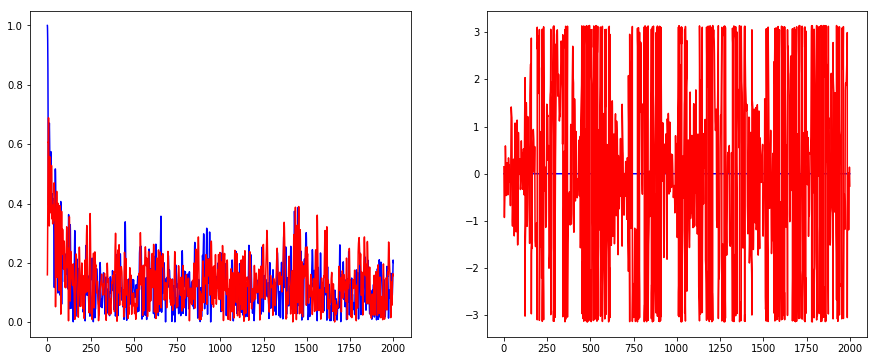

In [29]:
def get_community_op(phases,community_dict,axis=0):
    if axis==1:
        phases=phases.T
    R=np.zeros((phases.shape[0],len(set(community_dict.values()))))
    Psi=np.zeros((phases.shape[0],len(set(community_dict.values()))))
    for k in set(community_dict.values()):
        osc_list=[key for key,val in community_dict.items() if val ==k]
        Z=np.mean(np.exp(1j*phases[:,osc_list]),axis=1)
        R[:,k]=np.abs(Z)
        Psi[:,k]=np.angle(Z)
    if axis==1:
        R=R.T
        Psi=Psi.T
    return R,Psi
R,Psi=get_community_op(phases,community_dict,axis=0)   

num_communities=2
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for com in range(num_communities):
    plt.plot(tv,R[:,com],color_dict[com])
    #plt.xlim(0,1000)
plt.subplot(1,2,2)
for com in range(num_communities):
    plt.plot(tv,np.angle(np.exp(1j*(Psi[:,com]-Psi[:,0]))),color_dict[com])
    #plt.xlim(0,1000)

plt.show()